# Kinetic Energy

Computes and plots the mean and eddy surface kinetic energy for a set of four CESM2-MOM6 simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)

def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])


fs = 15

alpha_res = 2.
p_res = 50

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='04:00:00')
    cluster.scale(nw)
    client = Client(cluster)
client

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/42035/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/42035/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:35217,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/42035/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
%%time
res_funcs = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()

    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 1min 8s, sys: 6.85 s, total: 1min 15s
Wall time: 2min 37s


### Compute mean and eddy surface kinetic energy

In [5]:
%%time
depth = 0
MKE_list = []   
EKE_list = []   

for i in range(num_sims):
    sim = sims[i]
    sim.ds_type = sim.z_mode
    sim.open_files_by_year(sim.ocn_data_path, sim.z_end, start_year, end_year)
    sim.ds = sim.ds.sel(time=slice(start_date, end_date))
    sim.open_grid()

    ds = sim.ds
    index = (np.abs(ds.z_l - depth)).argmin().item()
    
    uo = ds.uo.isel(z_l=index)
    vo = ds.vo.isel(z_l=index)
    
    uo_interp = uo.interp(xq=ds.h.coords['xh'], method='linear')
    uo_interp = uo_interp.drop('xq')
    
    vo_interp = vo.interp(yq=ds.h.coords['yh'], method='linear')
    vo_interp = vo_interp.drop('yq')

    u_bar = uo_interp.mean('time')
    v_bar = vo_interp.mean('time')

    MKE = (0.5 * (u_bar**2 + v_bar**2)).compute()

    u_prime = uo_interp - u_bar
    v_prime = vo_interp - v_bar
    EKE = (0.5 * ((u_prime**2 + v_prime**2).mean('time'))).compute()
    
    MKE_list.append(MKE)
    EKE_list.append(EKE)

Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.z')
Opened grid and assigned coordinates.
CPU times: user 1min 6s, sys: 4.63 s, total: 1min 11s
Wall time: 3min 4s


### Difference plots for the mean surface kinetic energy

In [13]:
mean_diffs = []
for i in range(1,num_sims):
    diff = MKE_list[i].fillna(0)-MKE_list[0].fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    mean_diffs.append(diff)

eddy_diffs = []
for i in range(1,num_sims):
    diff = EKE_list[i].fillna(0)-EKE_list[0].fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],
                       'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    eddy_diffs.append(diff)

CPU times: user 26.5 s, sys: 179 ms, total: 26.7 s
Wall time: 27.9 s


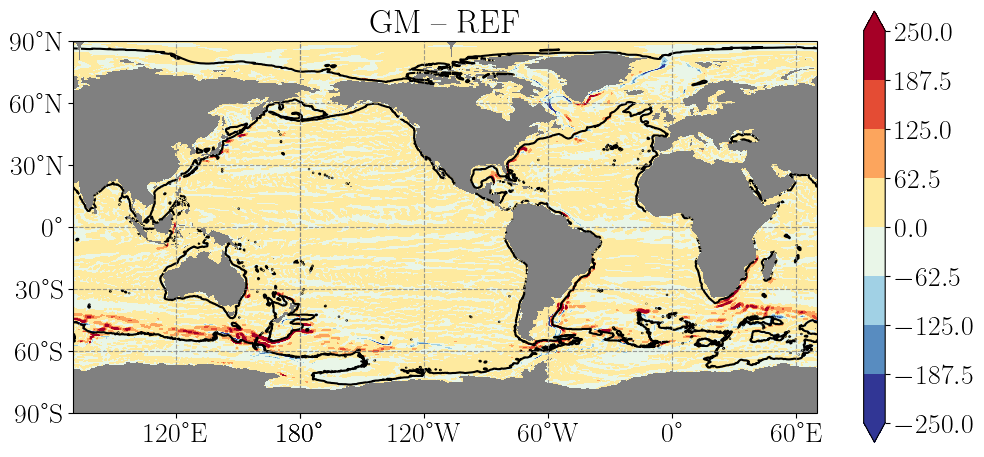

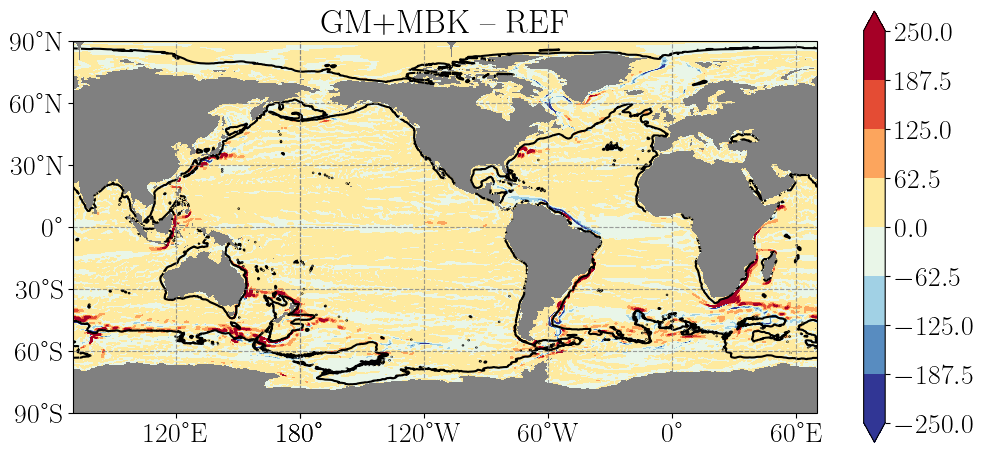

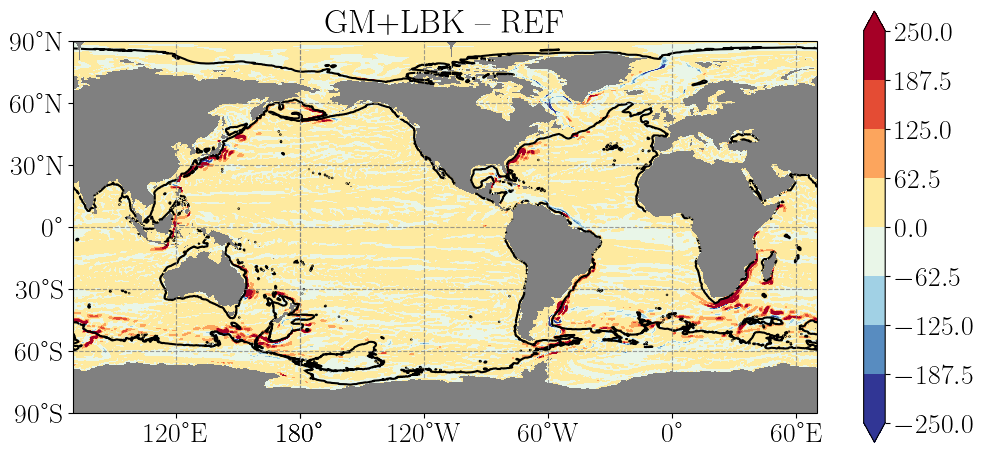

In [15]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -2.5*1e2, 2.5*1e2
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']

for sim, sname, R, diff in zip(sims[1:], snames[1:], res_funcs[1:], mean_diffs):
    title = sname + ' – REF'
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff*1e4,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+'MeanKE_'+title+'.png',dpi=300)

### Mean surface kinetic energy in the REF simulation

CPU times: user 3.03 s, sys: 50.6 ms, total: 3.09 s
Wall time: 4.18 s


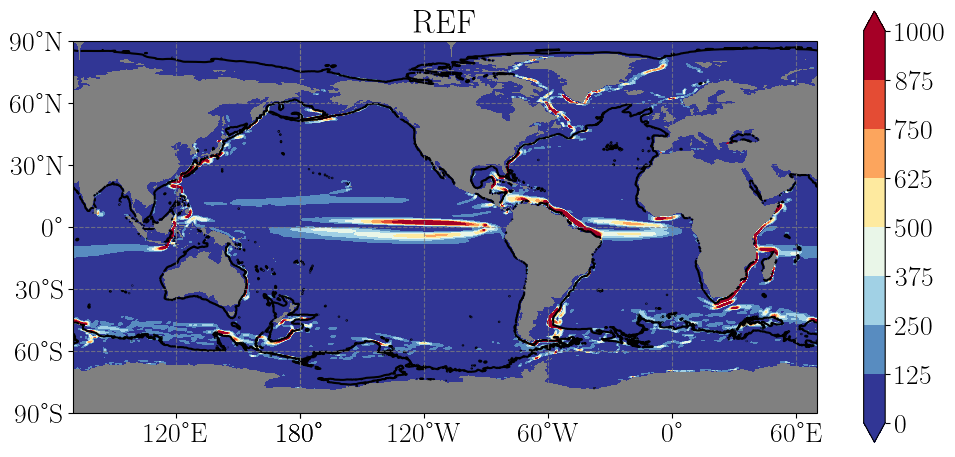

In [16]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 10*1e2
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']


sim = sims[0]
sname = snames[0]
R = res_funcs[0]

title = sname
# pass norm instead of vmin/vmax

field = MKE_list[0]
field = field.assign_coords({'geolon': sims[0].grid['geolon'],
                   'geolat': sims[0].grid['geolat']})
mappable = sim.plot_global_discrete(field*1e4,
                                    cmap=cmap,
                                    levels=levels,
                                    cbar_label= r'',
                                    title=title,
                                    figsize=(12,8),
                                    R=R,
                                    R_threshold=0.5,
                                    contour_color='k', 
                                    contour_linewidth=1.5, 
                                    contour_linestyle='-')

ax = plt.gca()

# set up graticules
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
plt.savefig(save_path+'MeanKE_'+title+'.png',dpi=300)

### Difference plots for the eddy surface kinetic energy

CPU times: user 32.4 s, sys: 230 ms, total: 32.7 s
Wall time: 34.7 s


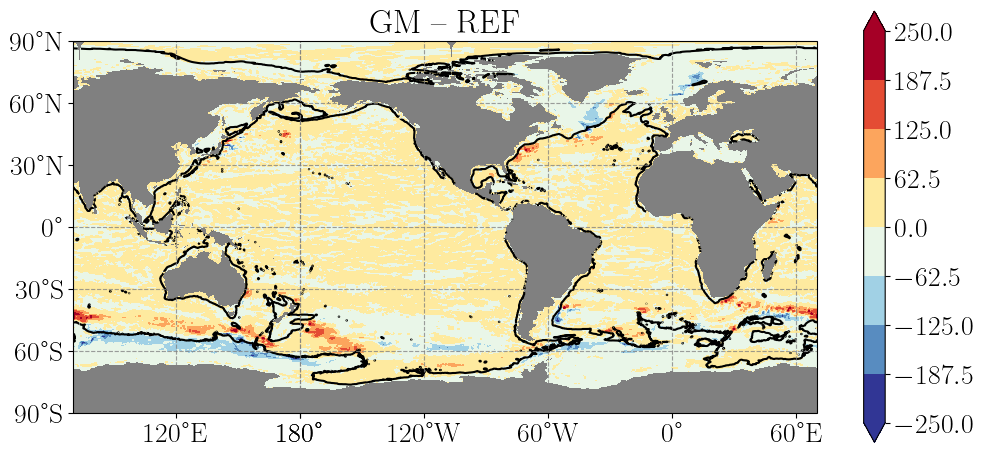

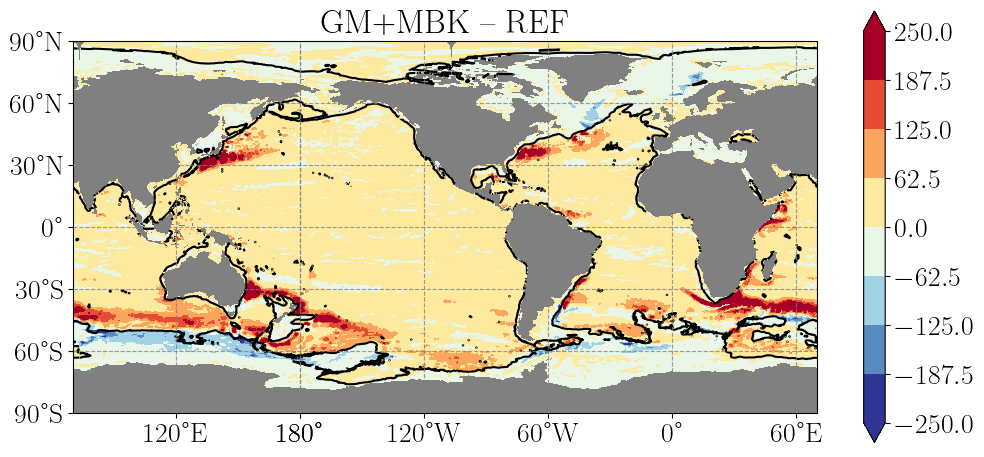

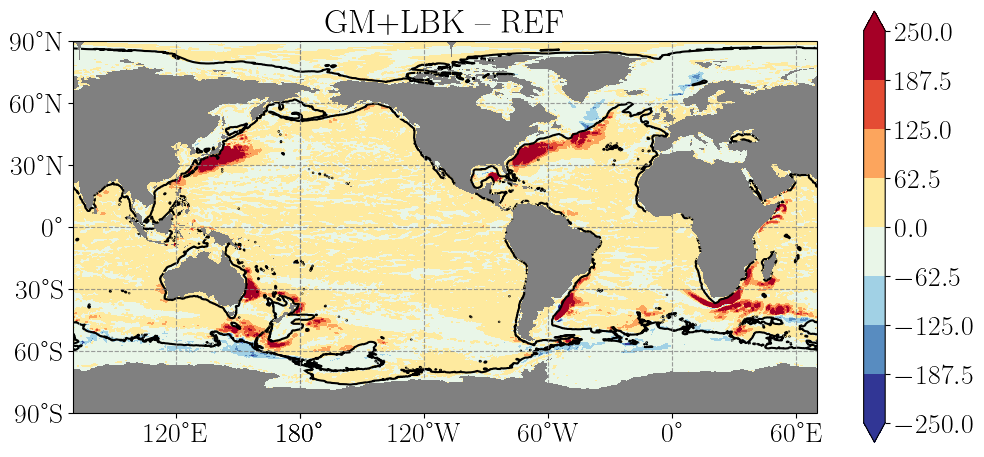

In [17]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -2.5*1e2, 2.5*1e2
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']

for sim, sname, R, diff in zip(sims[1:], snames[1:], res_funcs[1:], eddy_diffs):
    title = sname + ' – REF'
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff*1e4,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+'EddyKE_'+title+'.png',dpi=300)

### Eddy surface kinetic energy for the REF simulation

CPU times: user 2.29 s, sys: 34.9 ms, total: 2.33 s
Wall time: 2.46 s


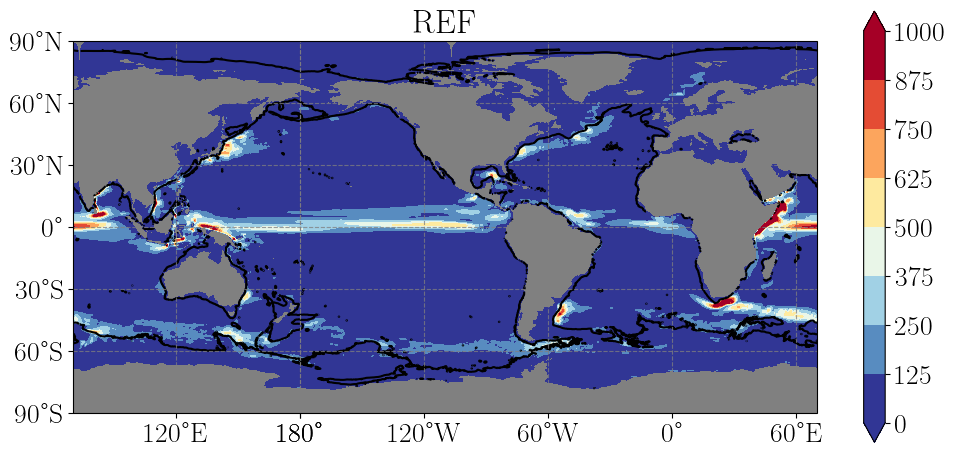

In [18]:
%%time
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 10*1e2
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']


sim = sims[0]
sname = snames[0]
R = res_funcs[0]

title = sname
# pass norm instead of vmin/vmax

field = EKE_list[0]
field = field.assign_coords({'geolon': sims[0].grid['geolon'],
                   'geolat': sims[0].grid['geolat']})
mappable = sim.plot_global_discrete(field*1e4,
                                    cmap=cmap,
                                    levels=levels,
                                    cbar_label= r'',
                                    title=title,
                                    figsize=(12,8),
                                    R=R,
                                    R_threshold=0.5,
                                    contour_color='k', 
                                    contour_linewidth=1.5, 
                                    contour_linestyle='-')

ax = plt.gca()

# set up graticules
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
plt.savefig(save_path+'EddyKE_'+title+'.png',dpi=300)

### Zonally integrate surface kinetic energy

In [12]:
def zonal_KE(ds, z_min=None, z_max=None):
    """
    Compute the zonal (xh) mean of the layer-integrated KE:
      KE_2D(xh,yh,t) = ( ∫ KE_3D dz ) / H
    then average that in xh over wet points only.

    Returns
    -------
    ke_zonal : xr.DataArray
       dims = (time, yh)
    """
    # 1) optionally restrict to a depth range
    ds1 = ds
    if z_min is not None or z_max is not None:
        ds1 = ds1.sel(z_l=slice(z_min, z_max))

    # 2) build Δz(zl) from the interfaces, pad to cell centers
    dz_iface = ds1['z_l'].diff('z_l')
    dz = dz_iface.pad({'z_l': (0, 1)},
                      constant_values=dz_iface.isel(z_l=-1))
    dz = dz.assign_coords(z_l=ds1['z_l'])

    # 3) mask to water columns under topo
    wet3d  = ds1['wet'] == 1
    topo3d = xr.broadcast(ds1['z_l'], ds1['depth_ocean'])[1]
    mask3d = wet3d & (ds1['z_l'] < topo3d)
    dz_wat  = dz.where(mask3d)              # (time? no, dz is time-indep) dims=(zl,yh,xh)

    # 4) total column thickness H(yh,xh)
    H = dz_wat.sum(dim='z_l')

    # 5) get your 3D KE = ½(u²+v²).  If you already have ds.KE, use it;
    #    otherwise compute from uo/vo at T-points.
    if 'KE' in ds1:
        KE3d = ds1['KE']
    else:
        uo = ds1.uo.interp(xq=ds1.h.xh).drop_vars('xq')
        vo = ds1.vo.interp(yq=ds1.h.yh).drop_vars('yq')
        KE3d = 0.5 * (uo**2 + vo**2)

    # 6) integrate in z with thickness weights, then divide by H
    ke2d = (KE3d * dz_wat).sum(dim='z_l') / H   # dims = (time, yh, xh)

    # 7) build a 2D wet mask for zonal averaging
    wet2d = ds1['wet'].isel(time=0).where(ds1['wet'].isel(time=0) == 1, 0).astype(float)

    # 8) compute zonal mean over xh
    ke_zonal = (ke2d * wet2d).sum(dim='xh') / wet2d.sum(dim='xh')
    ke_zonal.name = 'zonal_KE'

    return ke_zonal

In [13]:
%%time
zonal_kes = []
for i in range(num_sims):
    sim = sims[i]
    zonal_ke = zonal_KE(sim.ds).compute()
    zonal_kes.append(zonal_ke)

CPU times: user 46.7 s, sys: 2.16 s, total: 48.8 s
Wall time: 4min 51s


In [14]:
%%time
mean_zonal_kes = []
for i in range(num_sims):
    mean_zonal_ke = zonal_kes[i].mean(dim='time').compute()
    mean_zonal_kes.append(mean_zonal_ke)

CPU times: user 3.25 ms, sys: 231 µs, total: 3.48 ms
Wall time: 5.01 ms


100%|██████████| 4/4 [00:00<00:00, 400.07it/s]


CPU times: user 262 ms, sys: 79.3 ms, total: 341 ms
Wall time: 2.36 s


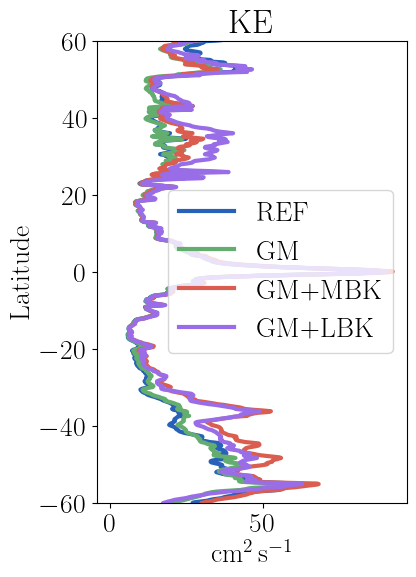

In [25]:
%%time
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale
labels = snames

plt.figure(figsize=(4,6))

ax = plt.subplot(111)

lw=3
for i in tqdm(range(num_sims)):
    ax.plot(mean_zonal_kes[i]*(100**2),sims[i].ds.yh,c=c[i],lw=lw,label=labels[i])

ax.set_ylim([-60,60])
#ax.set_xlim([0,10])
#ax.grid()
ax.set_ylabel('Latitude')
ax.set_xlabel(r'$\mathrm{cm^{2} \,s^{-1}}$')
title = 'KE'
ax.set_title(title)  
ax.legend()

plt.savefig(save_path+title+'zonal_legend.png',dpi=300)

100%|██████████| 4/4 [00:00<00:00, 279.22it/s]


CPU times: user 159 ms, sys: 7.72 ms, total: 167 ms
Wall time: 391 ms


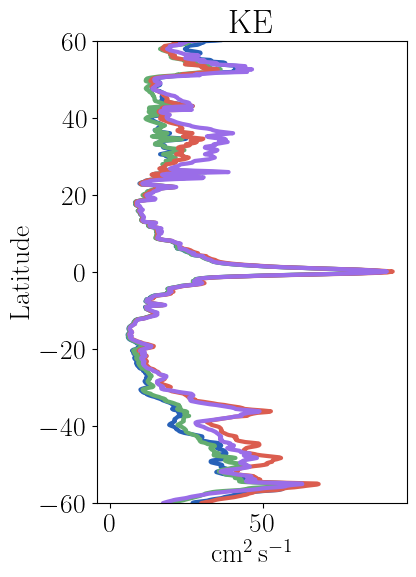

In [26]:
%%time
c = np.array([[39, 97, 184],  # Blue
              [99, 173, 111],   # Green
              [219, 93, 79],   # Red
              [154, 109, 232],  # Purple
              [255, 200, 61] ],  # Yellow], 
             dtype=np.float64) / 255.0  # Normalize to 0-1 scale
labels = snames

plt.figure(figsize=(4,6))

ax = plt.subplot(111)

lw=3
for i in tqdm(range(num_sims)):
    ax.plot(mean_zonal_kes[i]*(100**2),sims[i].ds.yh,c=c[i],lw=lw,label=labels[i])

ax.set_ylim([-60,60])
#ax.set_xlim([0,10])
#ax.grid()
ax.set_ylabel('Latitude')
ax.set_xlabel(r'$\mathrm{cm^{2} \,s^{-1}}$')
title = 'KE'
ax.set_title(title)  
#ax.legend()

plt.savefig(save_path+title+'zonal_no_legend.png',dpi=300)